**Equipo: RX 7900 XTX**
Integrantes:
  * José Pablo Martínez
  * Adrián Matute
  * Osvaldo del Valle
  * Andrés Callealta

# Introducción
 Para los pacientes de COVID-19 algo común para hacer una diagnosis de manera correcta, es una tomografía computarizada (CT, computer tomography). Este es un proceso que consume bastante tiempo, porque el radiólogo requiere observar a través de de cada seccion del CT y segmentar cada uno de ellos.

 El objetivo de este entregable es ayudar a las compañías que construyen software de CT, a que obtengan mejores resultados.
 De manera más exacta, necesitamos automatizar la segmentación de lesiones en los pulmones en las tomografías CT de pacientes con COVID-19.

 El desafío principal consta en detectar de manera precisa y segmentar las regiones del pulmon afectadas por el virus, viendo de manera clara algunos indicadores dentro de las tomografías los cuales indican la severidad de la enfermedad.
 Estas lesiones varian en forma, tamaño y distribución, dependiendo de la edad y género del afectado, ademas del estado de infección en el que se encuentra.

**Objetivos específicos de la competencia**
1. **Desarrollar modelos automáticos** que puedan identificar con presición las lesiones pulmonares en imágenes de tomografías computarizadas de pacientes con COVID-19.

2. Evaluar y comparar algoritmos de segmentación para seleccionar los más efectivos en la detección de lesiones pulmonares causadas por el virus.

3. Contribuir a la comunidad médica mediante la creación de herramientras que permitan realizar diagnósticos más rápidos y precisos en situaciones de sobrecarga del sistema de salud, especialmente durante pandemias como la del COVID-19.


**Relevancia de la segmentación en imágenes médicas para COVID-19:**

La segmentación semántica en imágenes médicas es una técnica crucial para detectar áreas específicas dentro de imágenes complejas, como los pulmones. En este caso, se clasifica cada píxel en categorías como áreas sanas o infectadas del pulmón. Este enfoque ayuda a los médicos a comprender mejor la extensión de la infección y a tomar decisiones informadas sobre el tratamiento del paciente. Además, la automatización de este proceso puede aumentar la eficiencia en el diagnóstivo y seguimiento de los pacientes.

La importancia de estas tareas de segmentación se centra en que permiten:
* Reducir el tiempo necesario para el diagnóstico, especialmente en tiempos de alta demanda.
* Mejorar la precisión y consistencia en la evaluación de las imágenes, al reducir la variabilidad entre cada diagnóstico realizado por diferentes médicos.
* Proporcionar una evaluación cuantitativa del grado del daño pulmonar, lo cual nos permite monitorear la evolución de la enfermedad y personalizar los tratamientos para cada paciente.


Para el desarrollo de nuestro modelo, nos basamos en el notebook de Kaggle disponible en ***Pytorch Baseline for Semantic Segmentation*** creado por Maede Maftouni. Este notebook proporcionó una estructura inicial para la segmentación semántica utilizando PyTorch y la arquitectura U-Net.

El código original sirvió como punto de partida para definir la carga de datos, el procesamiento de las imágenes y la arquitectura del modelo de segmentación. A partir de este enfoque, realizamos varias modificaciones y ajustes para adaptarlo específicamente a nuestra tarea. Esto incluyó la implementación de técnicas avanzadas de **data augmentation** y el ajuste de hiperparámetros clave para mejorar la precisión y robustez del modelo.

# Análisis de Datos
El conjunto de datos proporcionado está compuesto por imágenes de tomografías computarizadas (CT) de los pulmones de pacientes con COVID-19, específicamente enfocadas en la segmentación de áreas afectadas por el virus.

**Características del conjunto de datos:**

*Parte 1: Medseg*
* Origen: Imágenes axiales de tomografías computarizadas (CT) convertidas de imágenes JPG accesibles públicamente.
* Cantidad de muestras: 100 cortes axiales de CT de más de 40 pacientes con COVID-19.
* Dimensiones de las imágenes: Cada imagen tiene un tamaño de 512x512 píxeles.
* Estructura de los datos:
  * images_medseg.npy: 100 imágenes de entrenamiento (512x512).
  * masks_medseg.npy: 100 máscaras de entrenamiento con 4 canales:
    1. Canal 0: Opacidad en vidrio esmerilado ("ground glass").
    2. Canal 1: Consolidaciones.
    3. Canal 2: Otras áreas pulmonares.
    4. Canal 3: Fondo.

  * test_images_medseg.npy: 10 imágenes de prueba (512x512).

*Parte 2: Radiopedia*
* Origen: 9 volúmenes axiales volumétricos de CT de Radiopaedia, que incluyen tanto cortes positivos como negativos.

* Cantidad de muestras: 829 cortes en total, de los cuales 373 fueron evaluados como positivos y segmentados por un radiólogo.

* Dimensiones de las imágenes: También de tamaño 512x512 píxeles.

* Estructura de los datos:
  * images_radiopedia.npy: 829 imágenes de entrenamiento (512x512).
  * masks_radiopedia.npy: 829 máscaras de entrenamiento con los mismos 4 canales descritos anteriormente.


# Ética de uso de datos
Al usar imágenes médicas es importante recalcar la anonimidad de estas y que el dataset no contiene ninguna clase de valor o indicador que permita identificar a quien pertenecen. Todo esto tomando en cuenta el respeto a la privacidad y confidencialidad de los datos del paciente.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from segmentation_models_pytorch import Unet
from sklearn.model_selection import train_test_split
import os

In [ ]:
prefix = 'C:\Dev\Datasets'

In [ ]:
# Colab
from google.colab import drive
drive.mount('/content/drive')
prefix = 'drive/MyDrive/covid-segmentation/'

In [ ]:
# Cargar los archivos .npy
images_radiopedia = np.load(os.path.join(prefix, 'images_radiopedia.npy')).astype(np.float32)
masks_radiopedia = np.load(os.path.join(prefix, 'masks_radiopedia.npy')).astype(np.int8)
images_medseg = np.load(os.path.join(prefix, 'images_medseg.npy')).astype(np.float32)
masks_medseg = np.load(os.path.join(prefix, 'masks_medseg.npy')).astype(np.int8)

test_images_medseg = np.load(os.path.join(prefix, 'test_images_medseg.npy')).astype(np.float32)

In [ ]:
# Combinar los conjuntos de datos
train_images = np.concatenate((images_radiopedia, images_medseg), axis=0)
train_masks = np.concatenate((masks_radiopedia, masks_medseg), axis=0)

# Dividir en conjunto de entrenamiento y validación
train_images, val_images, train_masks, val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

# Preprocesamiento
Data augmentation es esencial para mejorar el entrenamiento del modelo, especialmente para modelos de visión de imágenes. En nuestro caso, ayuda a aumentar la diversidad de ejemplos de entrenamiento, y con eso mejorar la generalización, reconocimiento de patrones.

Modificar las imágenes del dataset, simula una mayor diversidad de imágenes, evita el overfitting, con este proceso el modelo no va a tratar de sobre-aprender detalles.

Hacer esas transformaciones aleatorias también ayuda al modelo a reconocer las características importantes de las imágenes independientemente de las condiciones, con eso reducimos la varianza del modelo final. Esto es importante porque este dataset es relativamente pequeño (100 imagenes), involucra a un pequeño número de de patentes (50), y podemos imaginar que una vez desplegado, el modelo se encuentre con otro tipo de escáner o pacientes con morfología muy diferente a las que se encuentran en los datos de entrenamiento.

Mas en detalle lo que le codigo hace:

Aleoratoriamente el las imagenes seran: rotacion, cambio de brillo, ambliadas horizontalmente.

Y todas seran: redimensionadas y normalisadas.

In [ ]:
# Data Augmentation
train_transform = A.Compose([
    # A.Resize(256, 256),  # Redimensionar las imágenes a un tamaño válido
    A.Resize(224, 224),  # Redimensionar las imágenes a un tamaño válido
    A.Rotate(limit=30, p=0.8),
    A.HorizontalFlip(p=0.5),
    A.ElasticTransform(p=0.2),
    # A.RandomBrightnessContrast(p=0.5),
    A.Normalize(mean=(0.485,), std=(0.229,))
])

val_transform = A.Compose([
    A.Resize(256, 256),  # Redimensionar las imágenes de validación a un tamaño válido
    A.Normalize(mean=(0.485,), std=(0.229,))
])

In [ ]:
# Dataset personalizado
class NumpyDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Imágenes son 2D
        mask = self.masks[idx]    # Máscaras también son 2D

        # Si hay transformaciones, aplicarlas
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Asegurar que las imágenes tengan el formato [canales, altura, ancho]
        image = torch.from_numpy(image).float().squeeze(-1)
        image = image.unsqueeze(0)  # Asegurarse de que el canal sea [1, altura, ancho]

        # Asegurar que las máscaras tengan el formato [clases, altura, ancho]
        mask = torch.from_numpy(mask).float().permute(2, 0, 1)  # Cambio de orden a [clases, altura, ancho]

        # # Verificar las dimensiones antes de pasar al modelo
        # print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

        return image, mask

# Crear DataLoaders
train_dataset = NumpyDataset(train_images, train_masks, transform=train_transform)
val_dataset = NumpyDataset(val_images, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

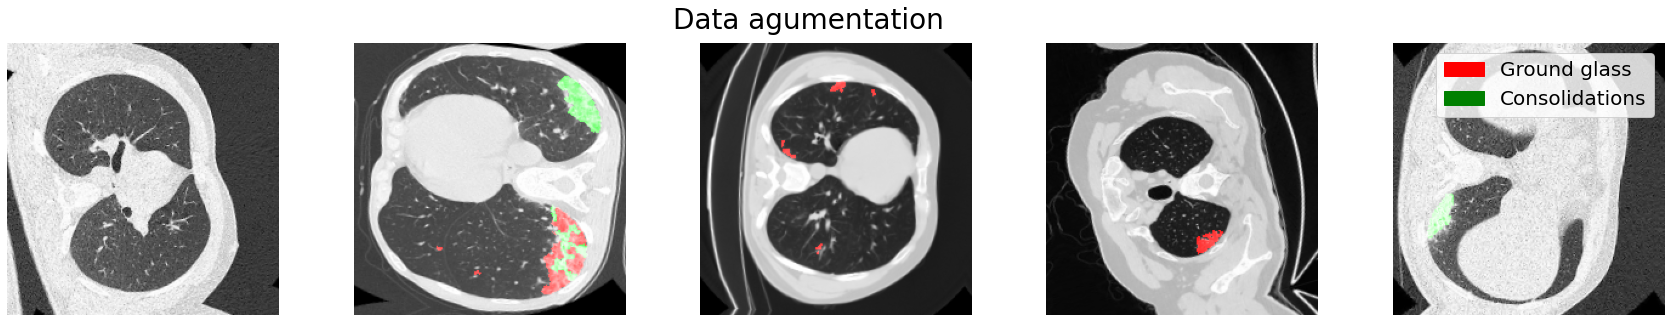

In [ ]:
num_samples = 5
samples = iter(train_loader)
images, masks = next(samples)

fig, axes = plt.subplots(1, num_samples, figsize=(30, 5))
fig.suptitle('Data agumentation', fontsize=28)

red_patch = mpatches.Patch(color='red', label='Ground glass')
green_patch = mpatches.Patch(color='green', label='Consolidations')
plt.legend(handles=[red_patch, green_patch], fontsize=20)

for i in range(num_samples):
        image = images[i, 0].cpu()
        groundglass = masks[i, 0].cpu()
        consolidations = masks[i, 1].cpu()

        image = (image - image.min()) / (image.max() - image.min())

        image_rgb = np.stack([image] * 3, axis=-1)

        mask_overlay = np.zeros_like(image_rgb)
        mask_overlay[..., 0] = groundglass # Red channel for ground glass
        mask_overlay[..., 1] = consolidations # Green channel for consolidations

        blended_image = np.clip(image_rgb + mask_overlay, a_min=0, a_max=1)


        axes[i].imshow(blended_image, origin='lower')
        axes[i].axis('off')

plt.show()


# Arquitectura del modelo
Descripción General del Modelo:
El modelo elegido para esta tarea de segmentación es U-Net con un codificador basado en EfficientNet-B0. Esta arquitectura es ampliamente utilizada en tareas de segmentación de imágenes médicas gracias a su capacidad de capturar tanto características globales como detalles finos de la imagen.

El U-Net es una red neuronal convolucional diseñada para la segmentación de imágenes. Su estructura en "U" nos permite que las características extraidas a diferentes niveles de la red se combinen de manera eficiente para mejorar la precisión de la segmentación.

El codificador, basado en EfficientNet-B0, es responsable de extraer características de la imagen de entrada, mientras que el decodificador reconstruye la imagen segmentada.

*Justificación de la Selección*:
* U-Net es particularmente efectiva en tareas de segmentación debido a su capacidad de combinar información de características locales y globales.

* EfficientNet-B0 como backbone mejora el proceso de extracción de características gracias a su diseño eficiente y compacto, que balancea el tamaño del modelo y la precisión.

* El uso de un codificadorr preentrenado como EfficientNet permite al modelo comenzar con características útiles, lo que mejora la convergencia y reduce el tiempo de entrenamiento.


**Detalles de la arquitectura del modelo:**
1. Codificador (Encoder - EfficientNet-B0):
* EfficientNet-B0 se usa como el backbone del codificador. Este extrae características a diferentes resoluciones usando bloques convolucionales con convoluciones de profunidad separables y convoluciones regualares.
* Número de capas convolucionales: EfficientNet-B0 consta de 18 capas convolucionales.
* Tamaño de Kernel: Las capas convolucionales utilizan tamaños de kernel de 3x3 y 5x5.
* Stride y Padding: Las de EfficientNet utilizan strides de 2 para realizar downsampling y un padding adecuado para conservar las dimensiones.
* Pooling: Se utiliza max-pooling para reducir la resolución de las imágenes, extrayendo las características.

2. Decodificador (Decoder - U-Net Decoding Path):
* Up-sampling: El decodificador usa operaciones de "upsampling" para aumentar la resolución de las características aprendidas y llevarlas de vuelta al tamaño de la imagen de entrada (256x256). Cada paso del decodificador incluye una concatenación con las características correspondientes del codificador para enriquecer la representación de las imágenes (skip connections).

* Capas convoluciones: Después de cada operación de upsampling, se aplican convoluciones de tamaño 3x3 con padding para refinar las características segmentadas.

* Capas Convolucionales: Después de cada operación de upsampling, se aplican convoluciones de tamaño 3x3 con padding para refinar las características segmentadas.

* Número de filtros: El decodificador tiene diferentes capas con un número decreciente de filtros, comenzando con 256 y disminuyendo a medida que se avanza hacia las capas superiores (128, 64, 32, 16).

3. Output Layer (Capa de Salida):

* Número de Clases: La capa de salida tiene 4 canales, uno para cada clase que se está segmentando (en este caso, 4 clases de COVID-19).

* Función de activación: No se utiliza activación en la última capa, ya que se usa la pérdida de CrossEntropy, que internamente calcula el softmax para obtener probabilidades para cada clase.


**Referencias**:

Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional networks for biomedical image segmentation. arXiv preprint arXiv:1505.04597.

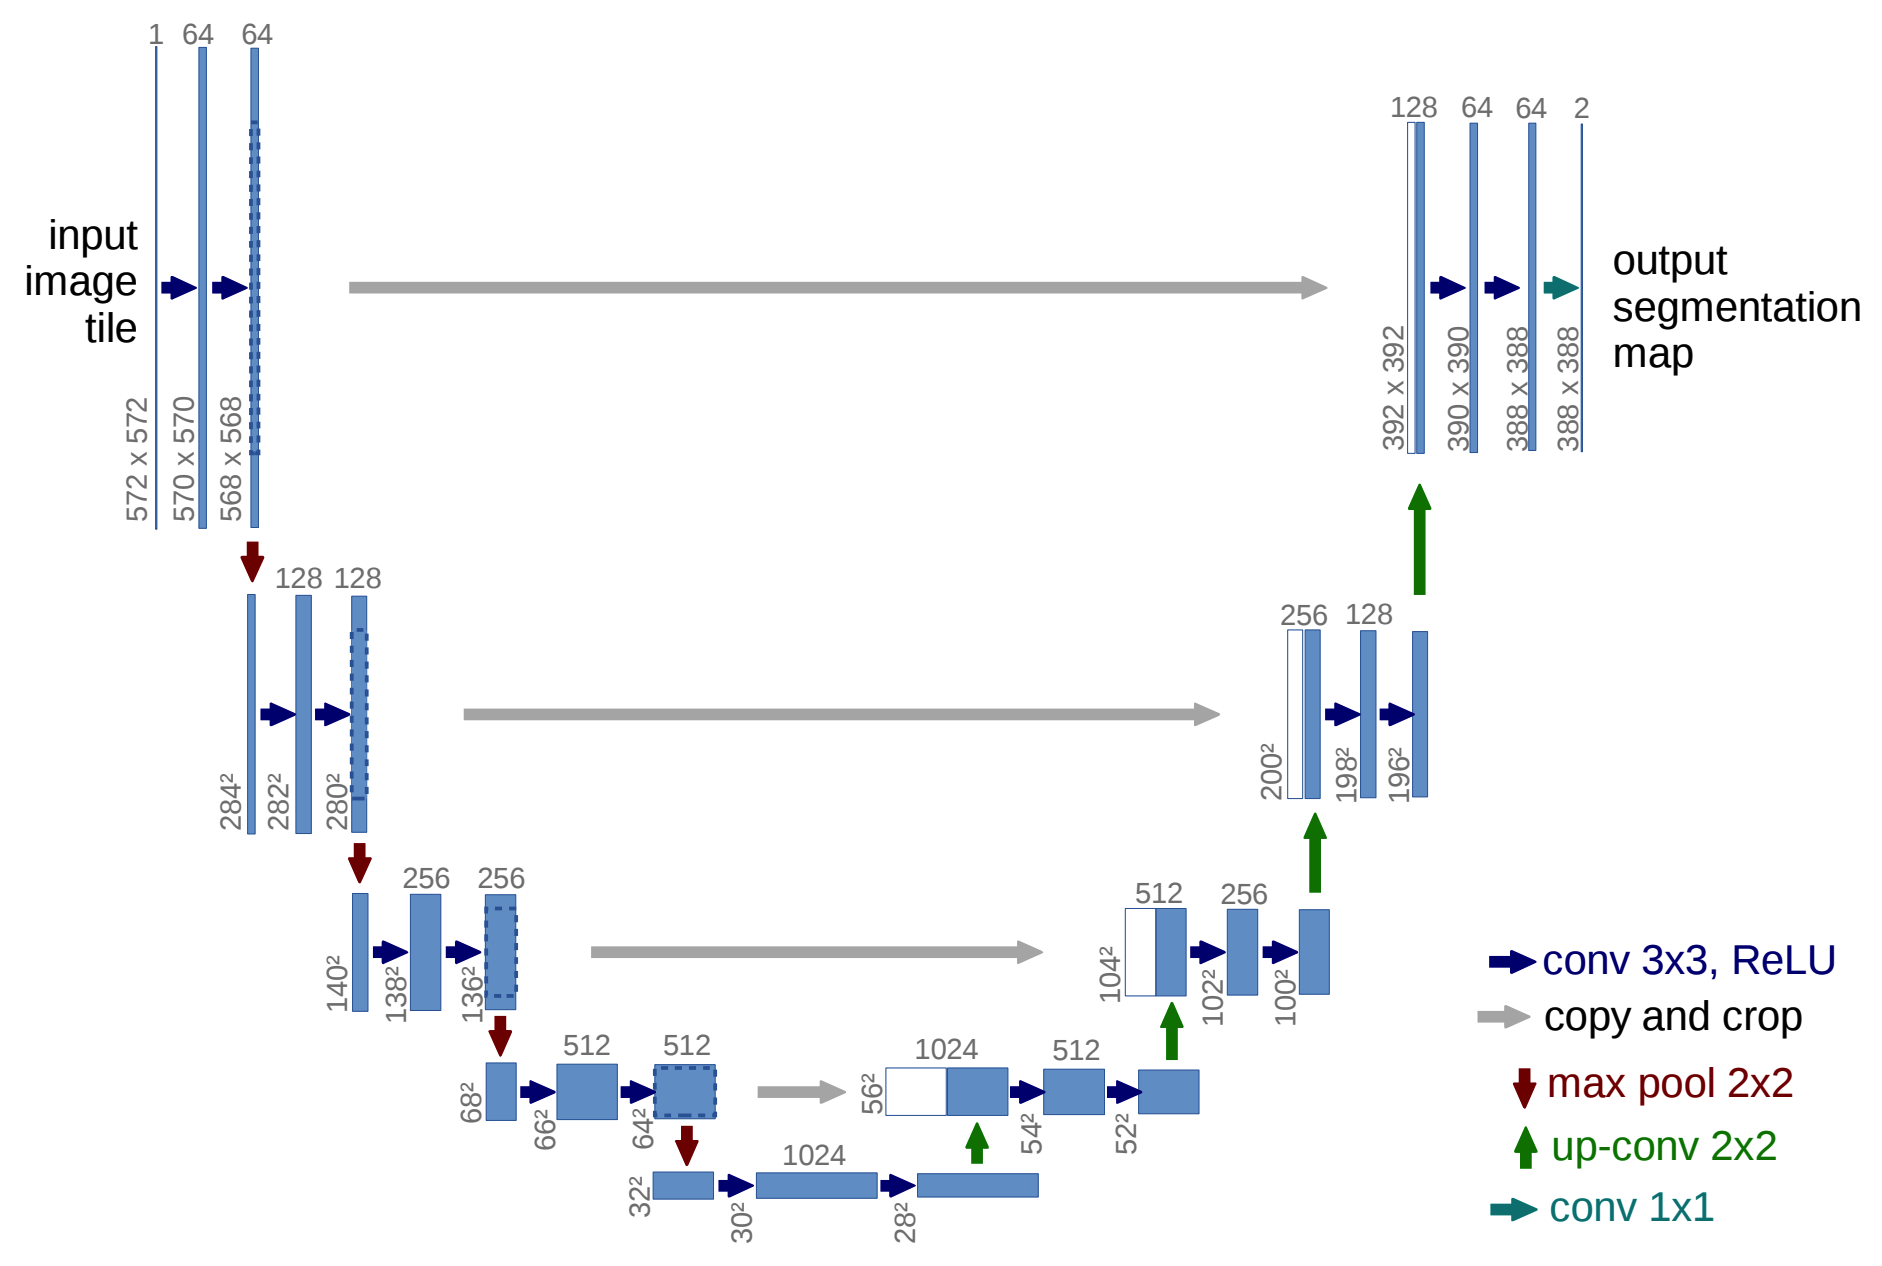

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definir el modelo U-Net con 4 clases
model = Unet(encoder_name='efficientnet-b0', in_channels=1, classes=4, encoder_weights='imagenet')
model = model.to(device)

# Cambiar la función de pérdida a CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW con weight decay

In [ ]:
# Función para calcular mIoU
def calculate_mIoU(predictions, masks, n_classes=4, smooth=1e-10):
    predictions = torch.argmax(predictions, dim=1).cpu().numpy()
    masks = torch.argmax(masks, dim=1).cpu().numpy()

    iou_per_class = []
    for cls in range(n_classes):
      pred_class = predictions == cls
      mask_class = masks == cls

      intersection = np.logical_and(pred_class, mask_class).sum()
      union = np.logical_or(pred_class, mask_class).sum()

      iou = (intersection + smooth) / (union + smooth)
      iou_per_class.append(iou)

    return np.nanmean(iou_per_class)

In [ ]:
# Función para calcular Accuracy
def pixel_accuracy(predictions, masks):
    predictions = torch.argmax(predictions, dim=1).cpu().numpy()
    masks = torch.argmax(masks, dim=1).cpu().numpy()  # Asegurar que las máscaras tengan la misma forma
    correct = np.equal(predictions, masks)
    accuracy = np.mean(correct)
    return accuracy

In [ ]:
# Función de evaluación (calcula val_loss, mIoU y accuracy)
def evaluate_model(model, criterion, val_loader, n_classes=4):
    model.eval()
    val_loss = 0
    miou_total = 0
    accuracy_total = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            miou_total += calculate_mIoU(outputs, masks, n_classes)
            accuracy_total += pixel_accuracy(outputs, masks)

    avg_val_loss = val_loss / len(val_loader)
    avg_miou = miou_total / len(val_loader)
    avg_accuracy = accuracy_total / len(val_loader)

    return avg_val_loss, avg_miou, avg_accuracy


In [ ]:
def plot_miou_accuracy(val_mious, val_accuracies):
    epochs = range(1, len(val_mious) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_mious, 'g', label='Validation mIoU')
    plt.title('mIoU over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('mIoU')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'm', label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, val_losses, 'r', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Entrenamiento del modelo
1)   Función de pérdida utilizada: Cross Entropy: cada pixel  de cada imagen va a ser tratado como una de las cuatro clases de pixeles. Aqui la funcion evalua la probabilidad de que cada pixel pertenezca a cada clase y luego lo compara a la clase real. Osea que va a tomar en cuanta la probabilidad para cada clase, y leugo va a favorisar la prediccion para la clase correcta.

2)   Optimizador y learning rate:

*   (Optimizador es lo que ajusta los pesos w del modelo, para minimizar la Lossfunction)
*   especificidad de Adam (y su derivada AdamW) es que guarda un historico de los gradientes para ajustar los pesos de manera mas adecuada.
*   AdamW inluye el "weight decay", el cual penaliza los pesos cuando se hacen muy grandes y con eso ayuda al modelo a ser mas simple, y generalizar mejor los datos. Fuera de metáforas, este parametro minimiza las posiblidades que el modelo aprenda demasiado de memoria (overfitting)el set de training, impidiendo a los pesos de ser muy altos.
 Aqui tenemos un weight decay de 1e-5= 0.00001.
*   Learning rate de 0.0001= 1e-4:


3)   Epochs y mini-batches:

*   10 epochs: itera 10 veces en todas la imagenes
*   Mini-batch: cada cuantas imagenes el modelo va a ajustar sus pesos: permite mas estabilidad en los gradientes, los cuales pueden cambiar mucho entre cada imagen.
*   Aqui tenemos un mini batch de 8, cada 8 imagenes el modelo ajustara sus pesos w.

4) Técnicas de regularizacion(PARA MINIMIZAR OVERFITTING):

*   weight decay de AdamW
*   data augmentation
*   normalización


5)Hardware: hemos usado GPU, que son especialmente útiles para hacer muchos calculos en paralelismo, lo que se nesesita en un Convolutional Network (CNN): los cuales hacen muchas manipulaciones de grandes matrices.

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_mious = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)  #transfer image/masks to gpu

            optimizer.zero_grad()  #reset grads
            outputs = model(images)   #do output (pred of masks for each pixel)
            loss = criterion(outputs, masks) #diff pred & mask
            loss.backward()     #backporpagation
            optimizer.step()   #update gradient w
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        avg_val_loss, avg_miou, avg_accuracy = evaluate_model(model, criterion, val_loader)
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_accuracy)
        val_mious.append(avg_miou)

        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"mIoU: {avg_miou:.4f}, "
              f"Accuracy: {avg_accuracy:.4f}")

    plot_miou_accuracy(val_mious, val_accuracies)
    plot_loss(train_losses, val_losses)

Epoch [1/10], Train Loss: 0.7797, Val Loss: 0.8676, mIoU: 0.2997, Accuracy: 0.8208
Epoch [2/10], Train Loss: 0.3280, Val Loss: 0.2999, mIoU: 0.4742, Accuracy: 0.9712
Epoch [3/10], Train Loss: 0.1969, Val Loss: 0.1567, mIoU: 0.4896, Accuracy: 0.9771
Epoch [4/10], Train Loss: 0.1388, Val Loss: 0.1077, mIoU: 0.5471, Accuracy: 0.9813
Epoch [5/10], Train Loss: 0.1091, Val Loss: 0.0864, mIoU: 0.5895, Accuracy: 0.9834
Epoch [6/10], Train Loss: 0.0937, Val Loss: 0.0722, mIoU: 0.5933, Accuracy: 0.9837
Epoch [7/10], Train Loss: 0.0808, Val Loss: 0.0636, mIoU: 0.5975, Accuracy: 0.9841
Epoch [8/10], Train Loss: 0.0712, Val Loss: 0.0576, mIoU: 0.6132, Accuracy: 0.9849
Epoch [9/10], Train Loss: 0.0650, Val Loss: 0.0533, mIoU: 0.6273, Accuracy: 0.9854
Epoch [10/10], Train Loss: 0.0593, Val Loss: 0.0503, mIoU: 0.6297, Accuracy: 0.9850


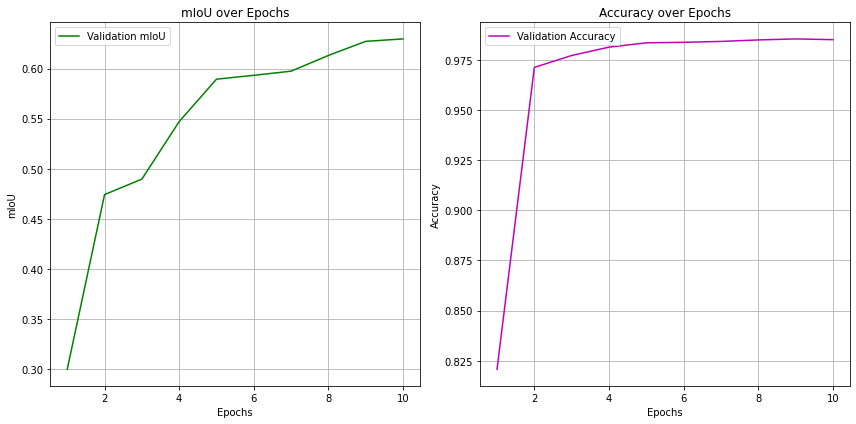

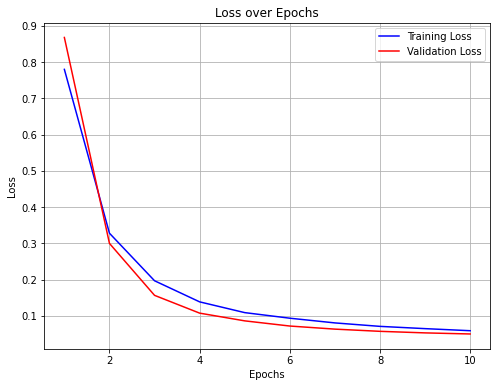

In [ ]:
# Entrenamiento del modelo
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

# Métricas de evaluación
Se utilizan las métricas mIoU (mean Intersection over Union) y Accuracy para evaluar que tan bien está funcionando el modelo. El IoU mide cuánto se parecen las áreas que el modelo predice y las áreas reales en las imágenes, lo que es muy útil para ver si el modelo está delimitando correctamente las zonas importantes. La mIoU es simplemente el promedio de este valor en todas las clases, lo que permite evaluar de manera más equilibrada cuando hay diferentes tipos de áreas a segmentar. Por otro lado el Accuracy indica cuántos píxeles fueron clasificados correctamente ofreciendo una visión general del rendimiento del modelo. Estas métricas son adecuadas porque no solo muestran la precisión de las predicciones sino también si el modelo está segmentando correctamente distintas áreas en imágenes complejas

# Resultados cuantitativos
El rendimiento del modelo basado en las métricas de mIoU y Accuracy, muestra un progreso a lo largo de las épocas de entrenamiento, donde se puede observar que el mIoU incrementa constantemente alcanzando un valor cercano al 0.58 lo que indica una mejora en la capacidad del modelo para segmentar correctamente las distintas áreas de las imágenes. Por otro lado el Accuracy también presenta una tendencia de mejoria logrando un valor del 98.3% lo que indica una alta proporción de píxeles correctamente clasificados.

In [ ]:
def plot_masks(images, masks, axes, num_samples, mask_class, channel=0):
    for i in range(num_samples):
        image = images[i, 0].cpu()
        mask = masks[i, mask_class].cpu()

        image = (image - image.min()) / (image.max() - image.min())
        mask = (mask > 0.5)

        image_rgb = np.stack([image] * 3, axis=-1)

        mask_overlay = np.zeros_like(image_rgb)
        mask_overlay[..., channel] = mask

        blended_image = np.clip(image_rgb + mask_overlay, a_min=0, a_max=1)


        axes[i].imshow(blended_image, origin='lower')


In [ ]:
# Visualizar predicciones
num_samples = 7
model.eval()
samples = iter(val_loader)
images, masks = next(samples)

with torch.no_grad():
    predictions = torch.sigmoid(model(images.to(device)))

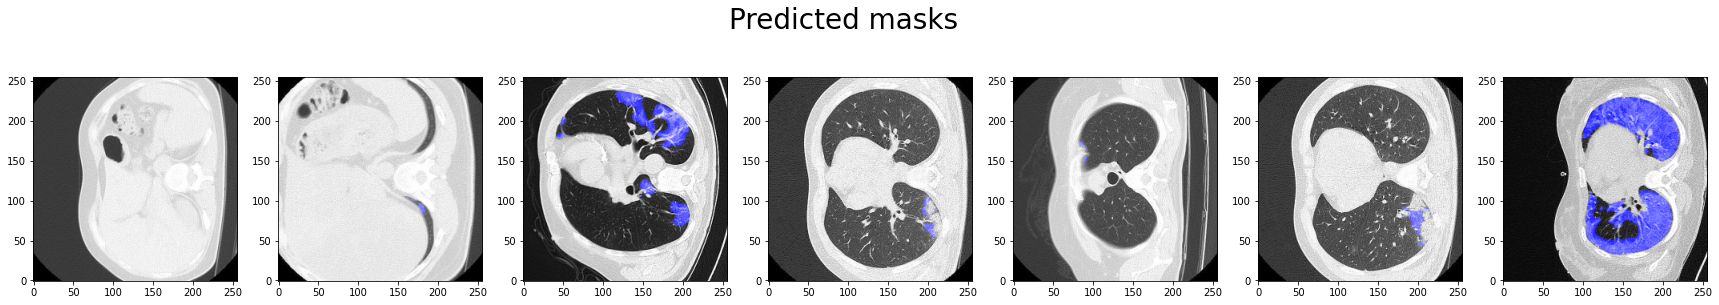

In [ ]:
fig, axes = plt.subplots(1, num_samples, figsize=(30, 5))
fig.suptitle('Predicted masks', fontsize=28)
plot_masks(images, predictions, axes, num_samples, mask_class=0, channel=2)
plt.show()

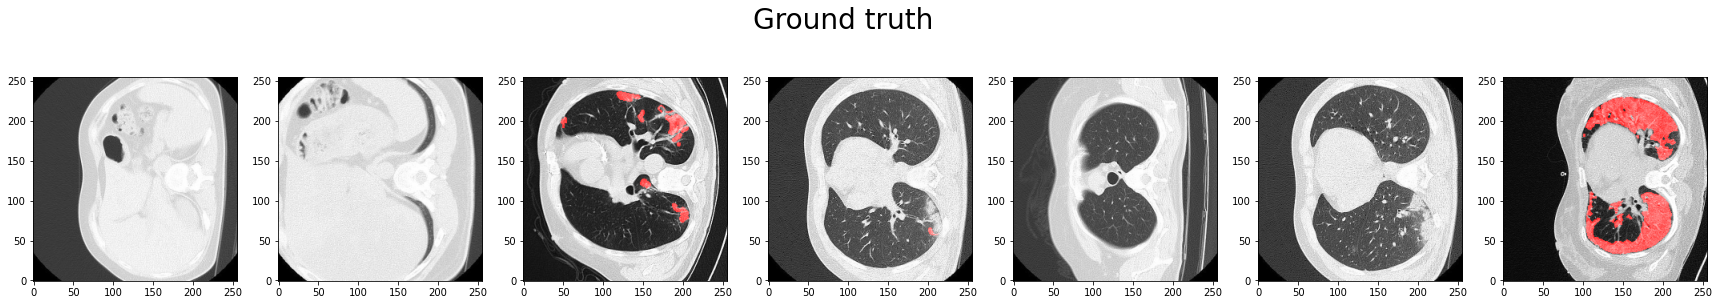

In [ ]:
fig, axes = plt.subplots(1, num_samples, figsize=(30, 5))
fig.suptitle('Ground truth (Ground Glass)', fontsize=28)
plot_masks(images, masks, axes, num_samples, mask_class=0)
plt.show()

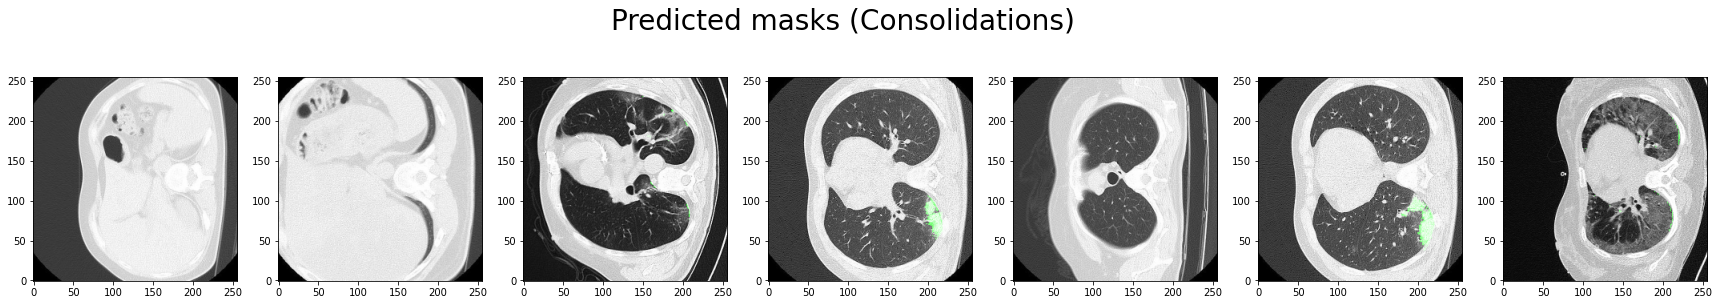

In [ ]:
fig, axes = plt.subplots(1, num_samples, figsize=(30, 5))
fig.suptitle('Predicted masks (Consolidations)', fontsize=28)
plot_masks(images, predictions, axes, num_samples, mask_class=1, channel=1)
plt.show()

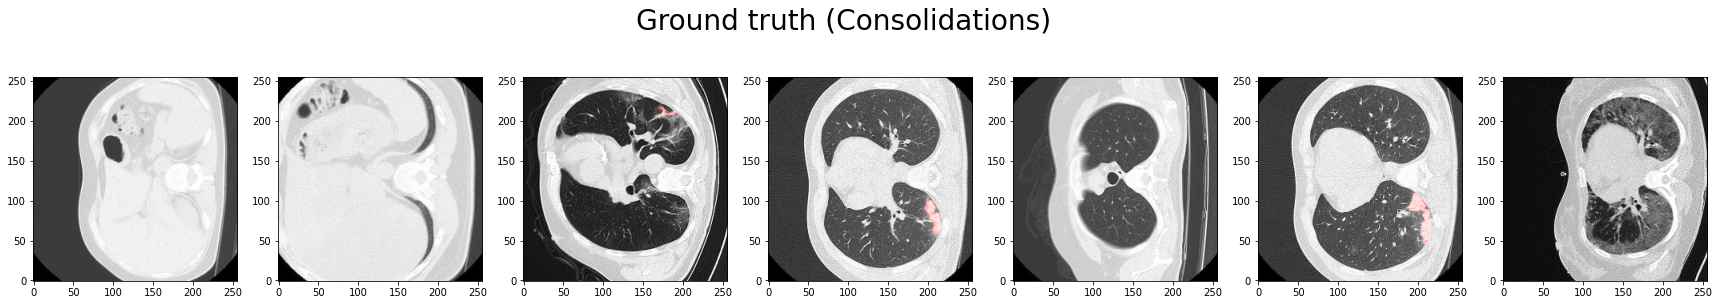

In [ ]:
fig, axes = plt.subplots(1, num_samples, figsize=(30, 5))
fig.suptitle('Ground truth (Consolidations)', fontsize=28)
plot_masks(images, masks, axes, num_samples, mask_class=1)
plt.show()

# Resultados visuales:
Podemos ver un buen ajuste para la predicción de las máscaras, particularmente cuando se trata de lesiones grandes.

Podemos ver cierta confusión al momento de predecir lesiones pequeñas u otros tipos de lesiones que no pertenecen a la máscara

# Conclusión

## Fortalezas del modelo
  El uso de U-Net nos ha permitido capturar  tanto características de las imágenes, lo cual es crucial para la tarea de segmentación. Además, el uso de EfficientNet-B0 optimiza la extracción de características, haciendo que el modelo sea eficiente en términos de memoria y procesamiento, pero con un buen rendimiento.

  El uso de técnicas de aumento de datos, como rotaciones, transformaciones elásticas y ajustes de brillo, ayuda a aumentar la variabilidad del conjunto de entrenamiento. Esto es especialmente importante en el caso de tareas de segmentación médica, donde la cantidad de datos es limitada.

  El uso de los pesos de imagenet permite que el modelo aproveche las características ya aprendidas por el codificador en otras tareas, mejorando la convergencia y reduciendo los tiempos de entrenamiento.


## Debilidades del modelo
 A pesar de que el modelo alcanza una alta precisión y mIoU en el conjunto de validación, puede haber problemas con la capacidad de generalización del modelo a nuevos datos no vistos. Esto es especialmente relevante si no se dispone de un conjunto de pruebas externo adecuado o si las imágenes utilizadas para entrenar son limitadas en términos de variabilidad.

## Mejoras potenciales

Probar diferentes hiperparámetros, como el learning rate, el tamaño del lote (batch size) o el número de capas en el decoder, podría mejorar aún más los resultados. También se podrían probar diferentes arquitecturas o versiones más avanzadas de U-Net, como U-Net++ o Attention U-Net.

Aunque se utiliza EfficientNet-B0 preentrenado, ajustar (fine-tune) las capas más profundas del backbone durante las últimas etapas del entrenamiento podría mejorar aún más el rendimiento, permitiendo al modelo aprender características específicas del dominio de las imágenes médicas.

# Desafíos superados
Durante el desarrollo de esta competencia de segmentación  de imágenes COVID-19, se enfrentaron varios desafíos técnicos y metodológicos que requirieron ajustes y estrategias para poder ser superados.

1. Un desafío clave fue el desbalance entre las diferentes clases en las máscaras de segmentación. Algunas clases tenían menos representación en comparación con el fondo o las estructuras no afectadas, lo que dificultaba que el modelo aprendiera a segmentarlas correctamente.

Para solucionarlo se experimentó con diferentes estrategias de pérdida, incluyendo la implementación de CrossEntropy Loss.

2. Durante las primeras fases del entrenamiento, el modelo mostró señales de sobreajuste, con un excelente rendimiento en el conjunto de entrenamiento, pero resultados significativamente peores en el conjunto de validación.

Para solucionarlo, se aplicaron varias técnicas para combatir el sobreajuste. Primero, se utilizó un backbone preentrenado (EfficientNet-B0), lo que permitió que el modelo partiera de características útiles y evitara el sobreentrenamiento en las primeras etapas. Además, se implementó weight decay en el optimizador y se ajustó el tamaño del lote para garantizar que el modelo generalizara mejor.

